 Task 8: **Energy Consumption Time Series Forecasting**

In [1]:
### 1. Import Libraries ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Regression model
from xgboost import XGBRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For scikit-learn scaling and train-test split
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd

# Replace with your actual dataset path
df = pd.read_csv('energydata_complete.csv')

# Parse the timestamp column (usually named 'date')
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# Set datetime index
df.set_index('date', inplace=True)

# Convert 'Appliances' column (energy consumption in Wh) to numeric (usually already numeric)
df['Appliances'] = pd.to_numeric(df['Appliances'], errors='coerce')

# Resample to hourly average and forward fill missing values (if any)
df = df.resample('H').mean().ffill()

print(df.head(), df.shape)  # Inspect data


                     Appliances     lights         T1       RH_1         T2  \
date                                                                          
2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778  19.200000   
2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028  19.268889   
2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556  19.925556   
2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333  20.251111   
2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333  20.587778   

                          RH_2         T3       RH_3         T4       RH_4  \
date                                                                         
2016-01-11 17:00:00  44.626528  19.790000  44.897778  18.932778  45.738750   
2016-01-11 18:00:00  44.438889  19.770000  44.863333  18.908333  46.066667   
2016-01-11 19:00:00  46.061667  20.052222  47.227361  18.969444  47.815556   
2016-01-11 20:00:00  45.632639  20.213889  47.268889  19

In [3]:
# Extract time-based features from datetime index
df['hour'] = df.index.hour                    # Hour of day (0-23)
df['day_of_week'] = df.index.dayofweek        # Day of week (0=Monday, 6=Sunday)
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Weekend flag (1 if Saturday/Sunday)
df['month'] = df.index.month                   # Month number (1-12)

# Create lag features to capture past consumption trends
# Lag 1 hour, 24 hours (1 day), and 168 hours (1 week)
df['lag_1'] = df['Appliances'].shift(1)
df['lag_24'] = df['Appliances'].shift(24)
df['lag_168'] = df['Appliances'].shift(168)

# After lagging, some rows will have NaN values (due to missing past data), so drop them
df.dropna(inplace=True)

# Check the updated dataframe
print(df.head())
print(df.shape)


                     Appliances     lights         T1       RH_1         T2  \
date                                                                          
2016-01-18 17:00:00   35.000000   0.000000  19.172222  41.175556  17.962222   
2016-01-18 18:00:00  300.000000   8.333333  19.100000  41.075556  17.812222   
2016-01-18 19:00:00  195.000000   8.333333  19.574444  42.057778  18.263750   
2016-01-18 20:00:00  558.333333  10.000000  20.258611  41.407083  19.100556   
2016-01-18 21:00:00  345.000000  11.666667  20.642222  40.164444  19.583788   

                          RH_2         T3       RH_3         T4       RH_4  \
date                                                                         
2016-01-18 17:00:00  41.530000  19.500000  40.693889  18.616667  38.084722   
2016-01-18 18:00:00  41.527778  19.357222  40.324444  18.457222  38.157222   
2016-01-18 19:00:00  42.203889  19.488889  40.265556  18.317778  38.393333   
2016-01-18 20:00:00  42.037778  20.196667  43.094444  18

In [4]:
# Choose the last 7 days (168 hours) as test data, rest as training
test_hours = 168  # 7 days * 24 hours

train = df.iloc[:-test_hours]
test = df.iloc[-test_hours:]

# Define feature columns to use for prediction
feature_cols = ['lag_1', 'lag_24', 'lag_168', 'hour', 'day_of_week', 'is_weekend', 'month']
target_col = 'Appliances'

print(f"Train shape: {train.shape}, Test shape: {test.shape}")


Train shape: (2954, 35), Test shape: (168, 35)


In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ARIMA ko sirf target column ki time series chahiye hoti hai (yahan 'Appliances')
# Order (p,d,q) tune bhi kiya ja sakta hai; abhi example ke liye (2,1,2)
arima_order = (2, 1, 2)
arima_model = ARIMA(train[target_col], order=arima_order).fit()

# Test set ke length ke hisaab se forecast generate karo
arima_pred = arima_model.forecast(steps=len(test))

# MAE (Mean Absolute Error) calculate karo
arima_mae = mean_absolute_error(test[target_col], arima_pred)

# RMSE calculate karo (squared=False ki jagah square root use karke)
arima_rmse = np.sqrt(mean_squared_error(test[target_col], arima_pred))

# Results print karo
print(f"ARIMA MAE: {arima_mae:.3f}, RMSE: {arima_rmse:.3f}")


ARIMA MAE: 60.969, RMSE: 94.656


In [9]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prophet ko input format chahiye with columns 'ds' (datetime) and 'y' (target)
prophet_df = train[[target_col]].reset_index().rename(columns={'date': 'ds', target_col: 'y'})

# Prophet model initialize aur fit karna
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Future dataframe create karo (test period jitna future ka time)
future = prophet_model.make_future_dataframe(periods=len(test), freq='H')

# Forecast generate karo
prophet_forecast = prophet_model.predict(future)

# Sirf test period ke predictions nikaalo
prophet_pred = prophet_forecast.set_index('ds')['yhat'][-len(test):]

# Evaluation metrics calculate karo (MAE and RMSE)
prophet_mae = mean_absolute_error(test[target_col], prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(test[target_col], prophet_pred))  # <- Fix here

# Print the results
print(f"Prophet MAE: {prophet_mae:.3f}, RMSE: {prophet_rmse:.3f}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lbc2191/3knb6ur3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lbc2191/5xf6pxl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38241', 'data', 'file=/tmp/tmp9lbc2191/3knb6ur3.json', 'init=/tmp/tmp9lbc2191/5xf6pxl2.json', 'output', 'file=/tmp/tmp9lbc2191/prophet_modelqgkahntc/prophet_model-20250817145257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 50.841, RMSE: 85.102


XGBoost MAE: 47.465, RMSE: 82.028

Model Performance Comparison:
     Model        MAE       RMSE
0    ARIMA  60.969079  94.656438
1  Prophet  50.840826  85.101595
2  XGBoost  47.464610  82.027944


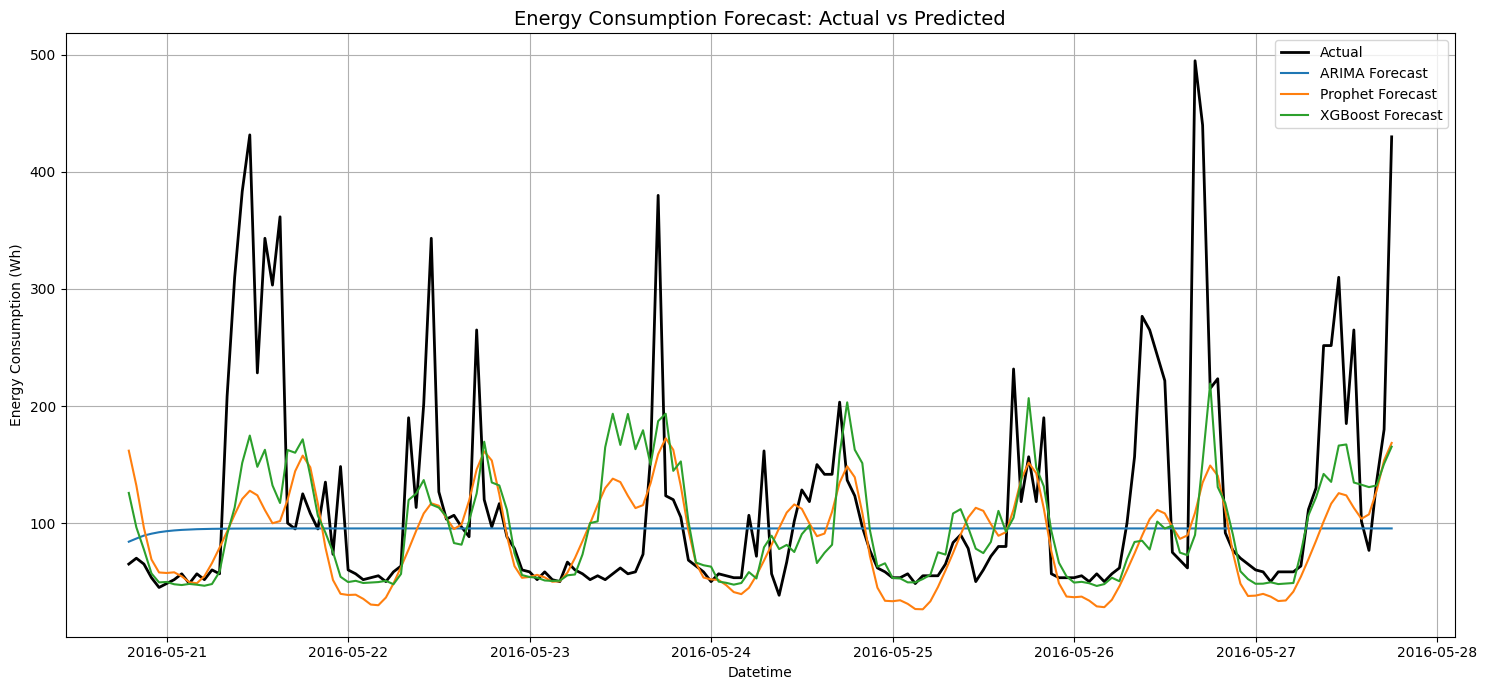

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Feature Engineering
# -----------------------------
# Time-based features nikaalna (hour, day of week, weekend)
train['hour'] = train.index.hour
train['dayofweek'] = train.index.dayofweek
train['is_weekend'] = train['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

test['hour'] = test.index.hour
test['dayofweek'] = test.index.dayofweek
test['is_weekend'] = test['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Jo features XGBoost ko chahiye honge
features = ['hour', 'dayofweek', 'is_weekend']

# -----------------------------
# Step 2: Train XGBoost Model
# -----------------------------
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(train[features], train[target_col])

# -----------------------------
# Step 3: Predict & Evaluate
# -----------------------------
xgb_pred = xgb.predict(test[features])

xgb_mae = mean_absolute_error(test[target_col], xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(test[target_col], xgb_pred))  # Avoids 'squared' error

print(f"XGBoost MAE: {xgb_mae:.3f}, RMSE: {xgb_rmse:.3f}")

# -----------------------------
# Step 4: Compare All Models
# -----------------------------
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [arima_mae, prophet_mae, xgb_mae],
    'RMSE': [arima_rmse, prophet_rmse, xgb_rmse]
})

print("\nModel Performance Comparison:")
print(results)

# -----------------------------
# Step 5: Plot Actual vs Predicted
# -----------------------------
plt.figure(figsize=(15, 7))
plt.plot(test.index, test[target_col], label='Actual', color='black', linewidth=2)

plt.plot(test.index, arima_pred, label='ARIMA Forecast')
plt.plot(test.index, prophet_pred, label='Prophet Forecast')
plt.plot(test.index, xgb_pred, label='XGBoost Forecast')

plt.title("Energy Consumption Forecast: Actual vs Predicted", fontsize=14)
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (Wh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
